In [1]:
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier
from pypfopt.plotting import plot_efficient_frontier

In [2]:
def variance(w, cov):
    return np.dot(w.T, np.dot(cov,w))

def returns(w, exp):
    return np.dot(w.T, exp)

In [3]:
DATA_PATH = '../data'
PRICES_PATH = os.path.join(DATA_PATH, 'prices')
SIMULATION_DATA_PATH = os.path.join(DATA_PATH, 'simulation data')
prices = pd.read_csv(os.path.join(PRICES_PATH, 'Spain_prices.csv'))

In [4]:
prices['price'] = prices['Price (EUR/MWhe)']
prices['time'] = pd.to_datetime(prices['Datetime (UTC)'])
prices.head()

,Country,ISO3 Code,Datetime (UTC),Datetime (Local),Price (EUR/MWhe),price,time
0,Spain,ESP,2015-01-01 00:00:00,2015-01-01 01:00:00,48.10,48.10,2015-01-01 00:00:00
1,Spain,ESP,2015-01-01 01:00:00,2015-01-01 02:00:00,47.33,47.33,2015-01-01 01:00:00
2,Spain,ESP,2015-01-01 02:00:00,2015-01-01 03:00:00,42.27,42.27,2015-01-01 02:00:00
3,Spain,ESP,2015-01-01 03:00:00,2015-01-01 04:00:00,38.41,38.41,2015-01-01 03:00:00
4,Spain,ESP,2015-01-01 04:00:00,2015-01-01 05:00:00,35.72,35.72,2015-01-01 04:00:00


In [5]:
df_list = []
for file_name in os.listdir(SIMULATION_DATA_PATH):
    df = pd.read_csv(os.path.join(SIMULATION_DATA_PATH, file_name),sep = ',', comment = '#')
    file_name_split = file_name.split('_')
    df['lat_lon'] = file_name_split[2]+ '_' + file_name_split[3]
    df_list.append(df)
production = pd.concat(df_list)

In [6]:
production['time'] = pd.to_datetime(production['time'])
production.head()

,time,local_time,electricity,lat_lon
0,2019-01-01 00:00:00,2019-01-01 01:00,0.251,37.3467_-5.6815
1,2019-01-01 01:00:00,2019-01-01 02:00,0.259,37.3467_-5.6815
2,2019-01-01 02:00:00,2019-01-01 03:00,0.261,37.3467_-5.6815
3,2019-01-01 03:00:00,2019-01-01 04:00,0.248,37.3467_-5.6815
4,2019-01-01 04:00:00,2019-01-01 05:00,0.243,37.3467_-5.6815


In [7]:
production['hour'] = production['time'].dt.hour
production['day'] = production['time'].dt.day
production['month'] = production['time'].dt.month
production['year'] = production['time'].dt.year

prices['hour'] = prices['time'].dt.hour
prices['day'] = prices['time'].dt.day
prices['month'] = prices['time'].dt.month
prices['year'] = prices['time'].dt.year

In [8]:
final_time_price = prices['time'].max() #- pd.Timedelta(days=1) + pd.Timedelta(hours=1)
start_time_price = final_time_price - pd.Timedelta(days=365)

In [9]:
mask_dates = (prices['time'] <= final_time_price) & (prices['time'] > start_time_price)
last_y_prices = prices[mask_dates]

In [10]:
last_y_prices.head()

,Country,ISO3 Code,Datetime (UTC),Datetime (Local),Price (EUR/MWhe),price,time,hour,day,month,year
83469,Spain,ESP,2024-07-09 21:00:00,2024-07-09 23:00:00,116.38,116.38,2024-07-09 21:00:00,21,9,7,2024
83470,Spain,ESP,2024-07-09 22:00:00,2024-07-10 00:00:00,107.94,107.94,2024-07-09 22:00:00,22,9,7,2024
83471,Spain,ESP,2024-07-09 23:00:00,2024-07-10 01:00:00,106.81,106.81,2024-07-09 23:00:00,23,9,7,2024
83472,Spain,ESP,2024-07-10 00:00:00,2024-07-10 02:00:00,104.22,104.22,2024-07-10 00:00:00,0,10,7,2024
83473,Spain,ESP,2024-07-10 01:00:00,2024-07-10 03:00:00,102.61,102.61,2024-07-10 01:00:00,1,10,7,2024


In [11]:
production.head()

,time,local_time,electricity,lat_lon,hour,day,month,year
0,2019-01-01 00:00:00,2019-01-01 01:00,0.251,37.3467_-5.6815,0,1,1,2019
1,2019-01-01 01:00:00,2019-01-01 02:00,0.259,37.3467_-5.6815,1,1,1,2019
2,2019-01-01 02:00:00,2019-01-01 03:00,0.261,37.3467_-5.6815,2,1,1,2019
3,2019-01-01 03:00:00,2019-01-01 04:00,0.248,37.3467_-5.6815,3,1,1,2019
4,2019-01-01 04:00:00,2019-01-01 05:00,0.243,37.3467_-5.6815,4,1,1,2019


In [12]:
df_revenue = pd.merge(production, last_y_prices, on=['hour','day','month'], how='inner')
df_revenue = df_revenue[['lat_lon','price','electricity','hour','day','month']]

In [13]:
# compute asset revenue
df_revenue['revenue'] = df_revenue['price'] * df_revenue['electricity']

In [14]:
monthly_rev = pd.pivot_table(df_revenue, values='revenue', index='month', columns='lat_lon', aggfunc='sum')
monthly_rev

lat_lon,37.3467_-5.6815,37.5021_-4.4298,37.6571_-2.4870,38.3250_-3.2432,38.4885_-5.0687,38.5089_-1.1831,38.7432_-6.7377,40.2523_-1.9654,40.3220_-0.1269,40.3617_-4.5602,40.5403_-6.2422,41.3479_1.0205,41.5629_-5.7467,41.5727_-1.7437,41.5824_-3.7648,41.6591_0.8423,42.4587_-8.3965,42.9692_-1.9821,43.0932_-4.2335,43.1742_-6.5667
month,,,,,,,,,,,,,,,,,,,,
1,20729.90512,15887.45191,22777.95817,18392.25521,22652.07083,30199.57953,22542.33137,34879.87617,43331.58040,26080.70445,28760.05265,26961.67910,27445.58538,42710.93964,27220.95585,22712.03050,18753.43070,22788.97590,24371.23862,19368.27864
2,20752.30000,13269.49122,18293.80596,17809.20448,16186.37946,23990.97947,18314.71189,25223.06850,26304.27739,16102.24043,18525.57125,17757.01501,19444.53068,27293.09895,21859.00050,15966.29783,19873.86774,24888.95951,24937.87714,21198.39356
3,10013.30521,7662.11174,9983.10311,11272.64470,12617.89203,12072.90654,13874.24107,15559.77792,17720.86688,12426.50399,14551.46399,11749.85205,17667.70894,19669.80938,15708.46112,10638.75845,13095.40741,13241.56792,15532.71422,13675.30280
4,7284.01804,5986.99432,6493.66977,6558.08519,7242.43943,7771.96340,7470.12195,8225.22787,8676.36533,5848.70701,6449.39989,6364.79952,8418.69136,7703.68603,7078.86952,5115.51835,6022.37363,4653.30825,5671.54745,5060.54601
5,4160.39954,2586.18568,2364.95744,3970.01487,4702.05445,2512.34970,5509.65427,4957.69996,5425.09844,4628.58526,6067.65327,3211.27469,6515.21215,6034.85081,5285.10982,3097.04649,4269.94055,2887.72187,3201.26302,3223.82220
6,13500.85362,11526.98928,10375.90936,12178.20843,16216.97011,11163.10758,18092.85881,18235.27516,11896.49825,12880.59071,14070.77512,13366.09243,17069.15633,13413.26258,15899.36201,13642.52937,9425.21540,12309.46234,10551.90663,8580.13521
7,12387.65513,10702.36305,12149.37177,12521.19767,14461.36933,12289.45821,17063.58837,17973.41664,12119.48360,11817.31075,14812.02323,10237.75241,17394.29264,15860.53850,16796.54410,10000.44728,12971.41035,11091.20934,9004.31806,9376.85607
8,13176.24656,10475.49466,9889.90993,11720.50704,12921.16753,11870.13068,16794.11755,14007.06886,11402.03676,12527.66843,15421.29457,10090.09288,18630.90709,16027.56198,16141.25342,9569.43145,13836.86026,10464.23488,10871.15014,11709.84612
9,10716.78242,8677.79331,9861.62208,10616.83920,12736.71610,12952.12133,15150.09103,16356.36123,15777.94232,14611.34499,17154.19130,10612.27552,22347.31143,18560.71940,18181.98157,9503.34668,17454.54050,12785.18990,13727.41878,14419.41684


In [15]:
cov = monthly_rev.cov()
exp = monthly_rev.sum()

In [16]:
cov

lat_lon,37.3467_-5.6815,37.5021_-4.4298,37.6571_-2.4870,38.3250_-3.2432,38.4885_-5.0687,38.5089_-1.1831,38.7432_-6.7377,40.2523_-1.9654,40.3220_-0.1269,40.3617_-4.5602,40.5403_-6.2422,41.3479_1.0205,41.5629_-5.7467,41.5727_-1.7437,41.5824_-3.7648,41.6591_0.8423,42.4587_-8.3965,42.9692_-1.9821,43.0932_-4.2335,43.1742_-6.5667
lat_lon,,,,,,,,,,,,,,,,,,,,
37.3467_-5.6815,6.513923e+07,5.145197e+07,8.552220e+07,6.118892e+07,6.974917e+07,1.000713e+08,7.283729e+07,8.719953e+07,9.568934e+07,6.802919e+07,6.993901e+07,7.701704e+07,8.447946e+07,1.001015e+08,8.159225e+07,6.333562e+07,6.650512e+07,7.076118e+07,9.449935e+07,7.851335e+07
37.5021_-4.4298,5.145197e+07,4.242527e+07,7.145065e+07,5.003487e+07,5.798671e+07,8.114097e+07,6.070877e+07,7.127215e+07,7.630076e+07,5.635226e+07,5.739370e+07,6.281205e+07,7.132323e+07,8.071807e+07,6.763607e+07,5.147027e+07,5.362786e+07,5.514314e+07,7.546136e+07,6.290216e+07
37.6571_-2.4870,8.552220e+07,7.145065e+07,1.290266e+08,8.666930e+07,9.831598e+07,1.441221e+08,1.018193e+08,1.251163e+08,1.386195e+08,9.879012e+07,9.928036e+07,1.096634e+08,1.243574e+08,1.451203e+08,1.183667e+08,8.810877e+07,9.285763e+07,9.540666e+07,1.339337e+08,1.107805e+08
38.3250_-3.2432,6.118892e+07,5.003487e+07,8.666930e+07,6.070089e+07,6.859071e+07,9.784882e+07,7.153650e+07,8.583201e+07,9.306864e+07,6.774043e+07,6.865363e+07,7.492303e+07,8.513162e+07,9.827868e+07,8.149009e+07,6.113583e+07,6.510252e+07,6.722669e+07,9.186122e+07,7.678261e+07
38.4885_-5.0687,6.974917e+07,5.798671e+07,9.831598e+07,6.859071e+07,8.060421e+07,1.114714e+08,8.387372e+07,9.853025e+07,1.065771e+08,7.873370e+07,8.010310e+07,8.726424e+07,9.966228e+07,1.125118e+08,9.365542e+07,7.143086e+07,7.375805e+07,7.533024e+07,1.042084e+08,8.671992e+07
38.5089_-1.1831,1.000713e+08,8.114097e+07,1.441221e+08,9.784882e+07,1.114714e+08,1.662243e+08,1.149524e+08,1.439484e+08,1.643130e+08,1.131255e+08,1.150011e+08,1.269522e+08,1.403154e+08,1.700824e+08,1.342988e+08,1.021638e+08,1.072948e+08,1.128407e+08,1.557115e+08,1.281898e+08
38.7432_-6.7377,7.283729e+07,6.070877e+07,1.018193e+08,7.153650e+07,8.387372e+07,1.149524e+08,8.861551e+07,1.009253e+08,1.066135e+08,8.101040e+07,8.293773e+07,8.933250e+07,1.049977e+08,1.144909e+08,9.802031e+07,7.340939e+07,7.829214e+07,7.840841e+07,1.085866e+08,9.119711e+07
40.2523_-1.9654,8.719953e+07,7.127215e+07,1.251163e+08,8.583201e+07,9.853025e+07,1.439484e+08,1.009253e+08,1.307650e+08,1.473951e+08,1.012591e+08,1.029471e+08,1.122387e+08,1.220509e+08,1.521983e+08,1.185442e+08,9.137511e+07,9.120791e+07,9.912373e+07,1.318819e+08,1.080092e+08
40.3220_-0.1269,9.568934e+07,7.630076e+07,1.386195e+08,9.306864e+07,1.065771e+08,1.643130e+08,1.066135e+08,1.473951e+08,1.787481e+08,1.146263e+08,1.166940e+08,1.281262e+08,1.334307e+08,1.802014e+08,1.303567e+08,1.026437e+08,1.007860e+08,1.123179e+08,1.508203e+08,1.218044e+08


In [17]:
# generar inversiones 
n_samples = 1000
n_locations = monthly_rev.shape[1]

w_np = np.random.uniform(size=(n_samples, n_locations))
w_np /= w_np.sum(axis=1, keepdims=True)
df_w = pd.DataFrame(w_np, columns=monthly_rev.columns)
df_w

lat_lon,37.3467_-5.6815,37.5021_-4.4298,37.6571_-2.4870,38.3250_-3.2432,38.4885_-5.0687,38.5089_-1.1831,38.7432_-6.7377,40.2523_-1.9654,40.3220_-0.1269,40.3617_-4.5602,40.5403_-6.2422,41.3479_1.0205,41.5629_-5.7467,41.5727_-1.7437,41.5824_-3.7648,41.6591_0.8423,42.4587_-8.3965,42.9692_-1.9821,43.0932_-4.2335,43.1742_-6.5667
0,0.102276,0.023509,0.030516,0.004595,0.009783,0.086446,0.087608,0.092977,0.105655,0.027471,0.057838,0.074695,0.062177,0.052641,0.039941,0.064392,0.009109,0.015800,0.040586,0.011987
1,0.038881,0.057380,0.076478,0.048602,0.064521,0.062345,0.067741,0.025766,0.006712,0.047960,0.058450,0.024169,0.071911,0.063763,0.013437,0.076541,0.071879,0.047274,0.070779,0.005409
2,0.076442,0.078976,0.014883,0.085574,0.023680,0.053155,0.045103,0.003914,0.089100,0.007502,0.045245,0.053026,0.041094,0.088758,0.049058,0.039027,0.083980,0.022938,0.047142,0.051403
3,0.049832,0.117550,0.019317,0.068987,0.021884,0.006328,0.090519,0.066119,0.041373,0.001032,0.082415,0.030069,0.017990,0.099093,0.040468,0.075305,0.007641,0.073745,0.045616,0.044715
4,0.058237,0.001944,0.085751,0.094891,0.010464,0.071745,0.022551,0.093355,0.085240,0.000494,0.045509,0.001428,0.011114,0.048231,0.076839,0.002103,0.060842,0.062499,0.077335,0.089428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.023917,0.046321,0.073467,0.008226,0.065702,0.040491,0.063409,0.051950,0.076587,0.031777,0.022472,0.052879,0.078417,0.047440,0.088904,0.061009,0.042478,0.031504,0.090191,0.002860
996,0.068532,0.063835,0.065374,0.082232,0.012766,0.061232,0.041919,0.087836,0.026417,0.033077,0.096522,0.018938,0.016378,0.071350,0.094759,0.038817,0.038221,0.016204,0.007338,0.058253
997,0.037139,0.078237,0.115769,0.052683,0.045740,0.020293,0.028055,0.003309,0.038213,0.045368,0.044526,0.024395,0.097884,0.054589,0.087780,0.028924,0.035276,0.069837,0.023265,0.068718
998,0.085826,0.023453,0.033397,0.091958,0.094610,0.082171,0.096013,0.024208,0.062140,0.026231,0.003612,0.056737,0.057887,0.015571,0.004982,0.045119,0.017445,0.010034,0.054524,0.114082


In [18]:
df_plot = pd.DataFrame(data = [], index=df_w.index)
df_plot['cov'] =  df_w.apply(variance, axis=1, cov=cov)
df_plot['exp'] = df_w.apply(returns, axis=1, exp=exp)

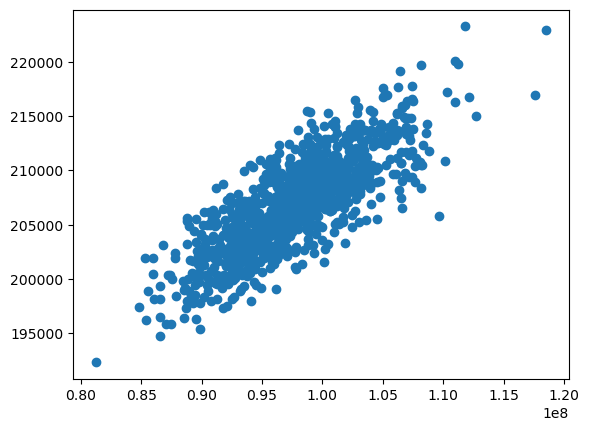

In [19]:
plt.scatter(x=df_plot['cov'], y=df_plot['exp'])
plt.show()

In [20]:
ef = EfficientFrontier(exp, cov, weight_bounds=(0,1))
weights = ef.min_volatility()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose=True)


OrderedDict([('37.3467_-5.6815', 0.0), ('37.5021_-4.4298', 1.0), ('37.6571_-2.4870', 0.0), ('38.3250_-3.2432', 0.0), ('38.4885_-5.0687', 0.0), ('38.5089_-1.1831', 0.0), ('38.7432_-6.7377', 0.0), ('40.2523_-1.9654', 0.0), ('40.3220_-0.1269', 0.0), ('40.3617_-4.5602', 0.0), ('40.5403_-6.2422', 0.0), ('41.3479_1.0205', 0.0), ('41.5629_-5.7467', 0.0), ('41.5727_-1.7437', 0.0), ('41.5824_-3.7648', 0.0), ('41.6591_0.8423', 0.0), ('42.4587_-8.3965', 0.0), ('42.9692_-1.9821', 0.0), ('43.0932_-4.2335', 0.0), ('43.1742_-6.5667', 0.0)])
Expected annual return: 14339451.8%
Annual volatility: 651346.8%
Sharpe Ratio: 22.02


(143394.51835000003, 6513.46802138099, 22.01507981298071)

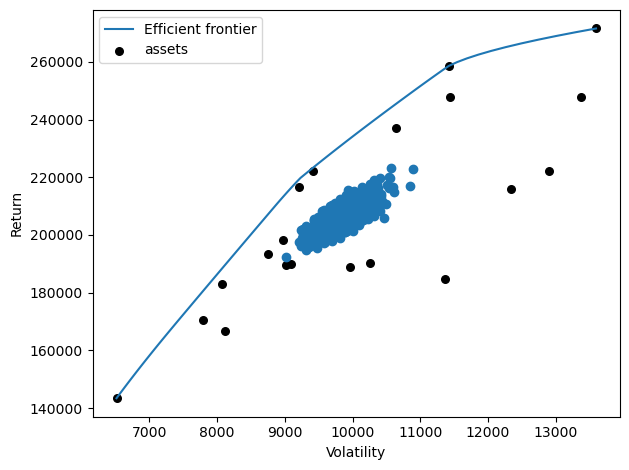

In [21]:
ef = EfficientFrontier(exp, cov,  weight_bounds=(0,1))
fig, ax = plt.subplots()
plot_efficient_frontier(ef, ax=ax, show_assets=True)
plt.scatter(x=np.sqrt(df_plot['cov']), y=df_plot['exp'])
plt.show()

<Axes: xlabel='Volatility', ylabel='Return'>

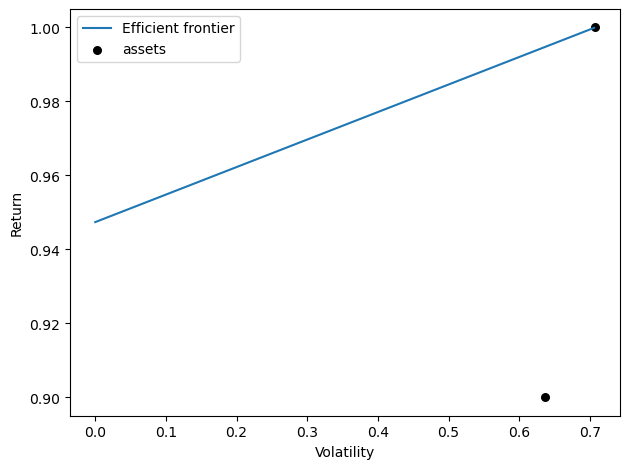

In [24]:
aux = pd.DataFrame({'A':[1,0],'B':[0,0.90]})
cov = aux.cov()
exp = aux.sum()

ef = EfficientFrontier(exp,cov,  weight_bounds=(0,1))
fig, ax = plt.subplots()
plot_efficient_frontier(ef, ax=ax, show_assets=True)


In [ ]:
# TODO: utilitzar els 10 anys de preus?